# Modules

In [1]:
from sklearn.datasets import load_iris, make_gaussian_quantiles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB


plt.style.use('ggplot')

# Common methods

In [2]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"]):
    """
    Plot confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list, optional): List of label names. Defaults to ["Negative", "Positive"].
        show_precision_recall (bool, optional): Whether to show precision and recall. Defaults to True.

    Returns:
        None
    """
    plt.figure(figsize=(4, 4), dpi=100)
    sns.set_style("whitegrid")
    cm = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(cm, index=labels,
                         columns=["Predicted " + labels[0], "Predicted " + labels[1]])
    sns.heatmap(df_cm, annot=True, fmt='g')

    plt.show()

In [3]:
def value_distribution(df):
    """
    Print value distribution for each column in the DataFrame.

    Args:
        df (DataFrame): Input DataFrame.

    Returns:
        None
    """
    num_rows = len(df)
    for column in df.columns:
        print("Value distribution for column:", column)
        value_counts = df[column].value_counts()
        percentages = (value_counts / num_rows) * 100
        for value, count, percent in zip(value_counts.index, value_counts, percentages):
            print(f"{value}: {count} ({percent:.2f}%)")
        print("\n")

# Load dataset

In [4]:
BASE_URL = "/kaggle/input/sms-spam-collection-dataset/"
RANDOM_SEED = 0

In [5]:
df = pd.read_csv(BASE_URL+"spam.csv", encoding='ISO-8859-1')

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Clean dataset

Converts column values to strings, combines them into a new 'Message' column, and removes original columns, streamlining DataFrame structure.

In [7]:
# Convertire i valori delle colonne in stringhe, escludendo NaN
for col in df.columns[1:]:
    df[col] = df[col].astype(str).replace('nan', '')

# Unire i contenuti delle colonne dalla seconda fino all'ultima in una nuova colonna
df['Message'] = df.iloc[:, 1:].apply(lambda x: ''.join(x.dropna()), axis=1)

# Rimuovere le colonne di partenza
df.drop(df.columns[1:-1], axis=1, inplace=True)

In [8]:
df.isnull().sum()

v1         0
Message    0
dtype: int64

The code maps values in the 'v1' column using a dictionary, converting 'ham' to 0 and 'spam' to 1.







In [9]:
spam_map = {"ham": 0, "spam": 1}
df["v1"] = df["v1"].map(lambda x: spam_map[x])

In [10]:
df.rename(columns={'v1': 'Spam'}, inplace=True)
df.head()

,Spam,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
X = df["Message"]
y = df["Spam"]

# Dataset exploration

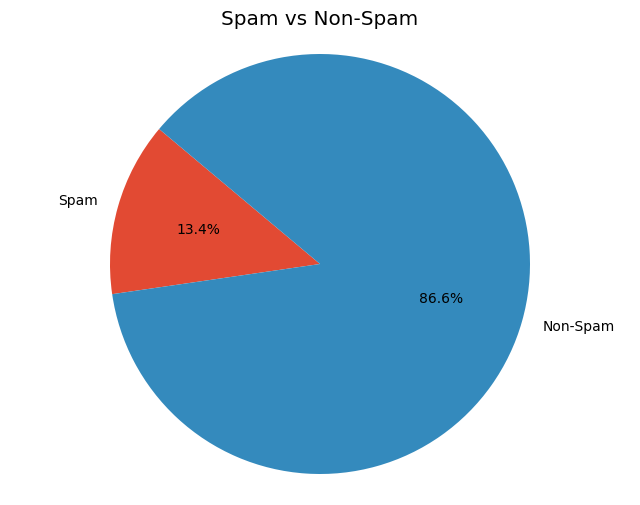

In [12]:
# Calcolare il conteggio di spam e non-spam
spam_count = df['Spam'].sum()
non_spam_count = len(df) - spam_count

# Etichette per le fette
labels = ['Spam', 'Non-Spam']

# Dati per il grafico a torta
sizes = [spam_count, non_spam_count]

# Creare il grafico a torta
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Spam vs Non-Spam')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


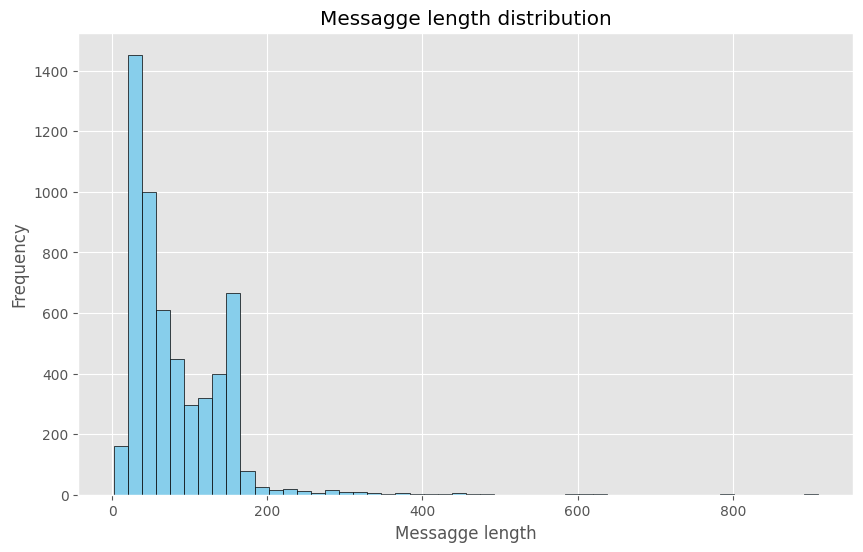

In [13]:
# Calcolare la lunghezza dei messaggi
message_lengths = df['Message'].apply(len)

# Creare l'istogramma
plt.figure(figsize=(10, 6))
plt.hist(message_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Messagge length distribution')
plt.xlabel('Messagge length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Word Cloud
A word cloud displays the most frequent words in the text, sized according to their frequency. The most frequent words appear larger and the less frequent ones smaller.

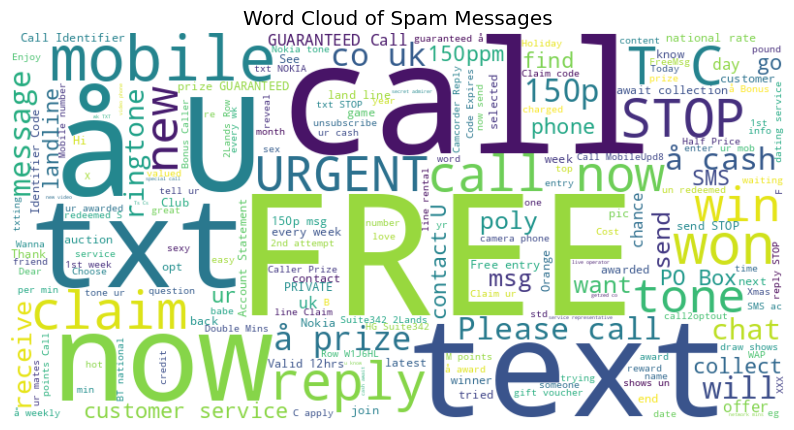

In [14]:
from wordcloud import WordCloud

# Create a single string containing all spam messages
spam_messages = ' '.join(df.query('Spam == 1')['Message'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_messages)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Spam Messages')
plt.axis('off')
plt.show()


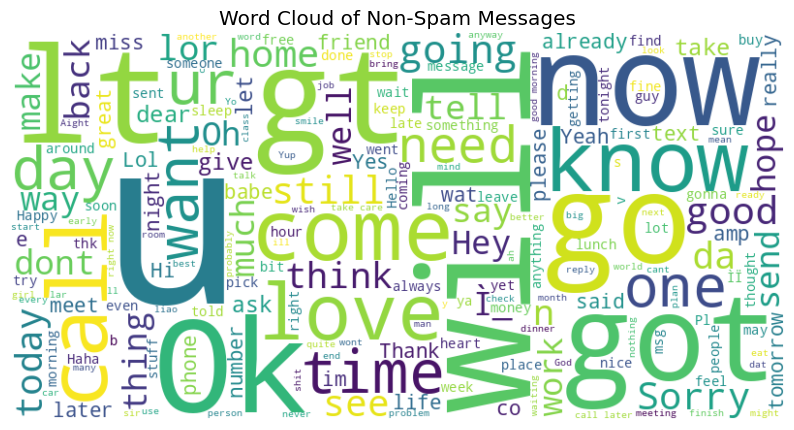

In [15]:
from wordcloud import WordCloud

# Create a single string containing all spam messages
spam_messages = ' '.join(df.query('Spam == 0')['Message'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_messages)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Non-Spam Messages')
plt.axis('off')
plt.show()

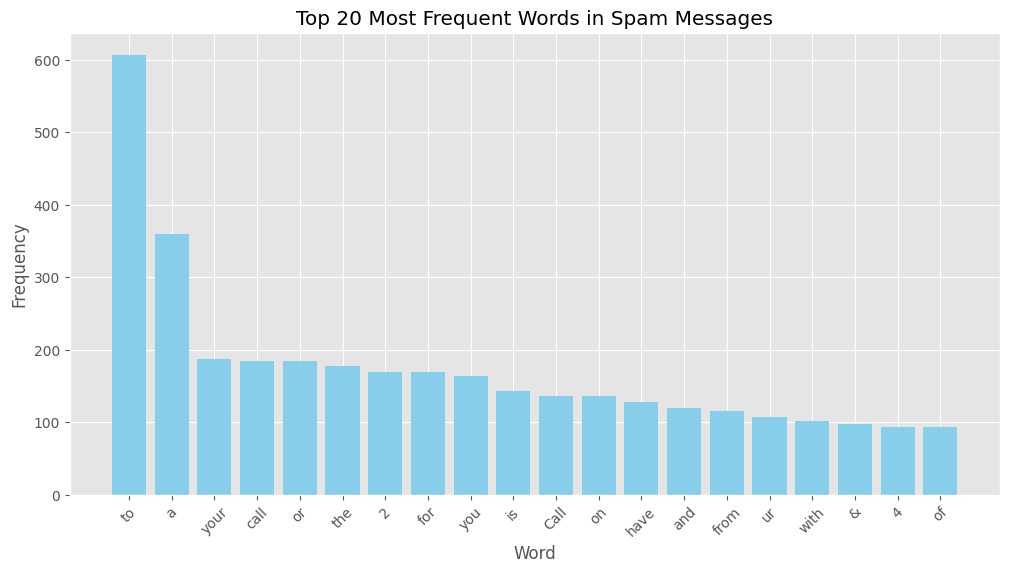

In [16]:
from collections import Counter

# Create a list of all words in the spam messages
spam_words = ' '.join(df.query('Spam == 1')['Message']).split()

# Count the occurrences of each word
word_counts = Counter(spam_words)

# Create a DataFrame with the words and their frequencies
word_counts_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(word_counts_df['Word'], word_counts_df['Frequency'], color='skyblue')
plt.title('Top 20 Most Frequent Words in Spam Messages')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


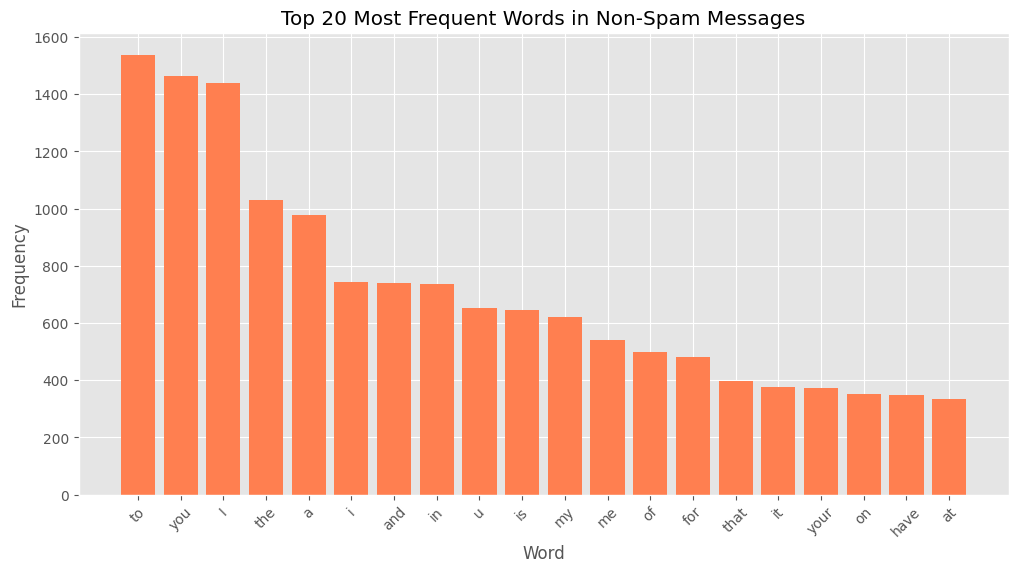

In [17]:
from collections import Counter

# Create a list of all words in the spam messages
spam_words = ' '.join(df.query('Spam == 0')['Message']).split()

# Count the occurrences of each word
word_counts = Counter(spam_words)

# Create a DataFrame with the words and their frequencies
word_counts_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Frequency'])

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(word_counts_df['Word'], word_counts_df['Frequency'], color='coral')
plt.title('Top 20 Most Frequent Words in Non-Spam Messages')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# TfidfVectorizer

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=RANDOM_SEED)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english", max_features=50000)
X_train = tfidf.fit_transform(X_train.tolist())
X_test = tfidf.transform(X_test)
X_train.shape

(3900, 6899)

## Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1491
           1       0.76      1.00      0.86       181

    accuracy                           0.97      1672
   macro avg       0.88      0.98      0.92      1672
weighted avg       0.97      0.97      0.97      1672



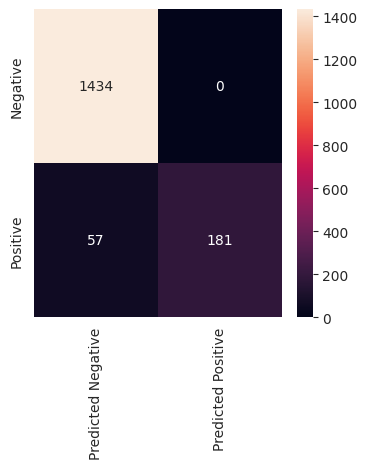

In [20]:
benb = BernoulliNB()
benb.fit(X_train, y_train)
report = classification_report(benb.predict(X_test), y_test)
print(report)
plot_confusion_matrix(y_test, benb.predict(X_test))


### SMOTE Version

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1469
           1       0.85      1.00      0.92       203

    accuracy                           0.98      1672
   macro avg       0.93      0.99      0.95      1672
weighted avg       0.98      0.98      0.98      1672



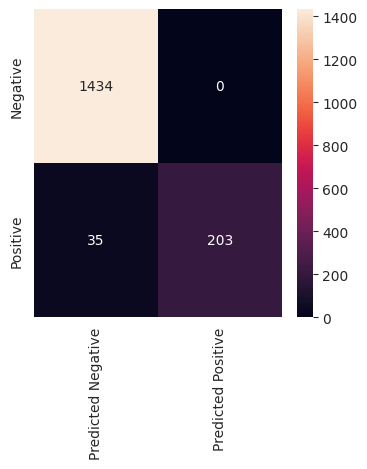

In [21]:
from imblearn.over_sampling import SMOTE
X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train, y_train)
benb = BernoulliNB()
benb.fit(X_resampled_smote, y_resampled_smote)
report = classification_report(benb.predict(X_test), y_test)
print(report)
plot_confusion_matrix(y_test, benb.predict(X_test))

### ADASYN version

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1471
           1       0.84      1.00      0.92       201

    accuracy                           0.98      1672
   macro avg       0.92      0.99      0.95      1672
weighted avg       0.98      0.98      0.98      1672



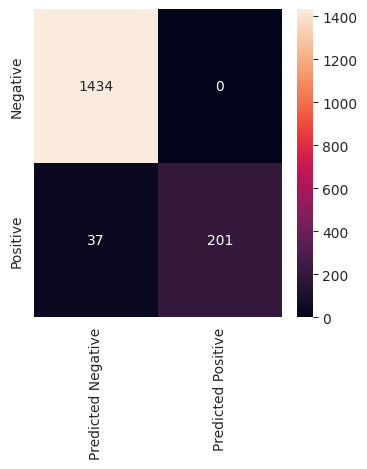

In [22]:
from imblearn.over_sampling import ADASYN
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(X_train, y_train)
benb = BernoulliNB()
benb.fit(X_resampled_adasyn, y_resampled_adasyn)
report = classification_report(benb.predict(X_test), y_test)
print(report)
plot_confusion_matrix(y_test, benb.predict(X_test))

## Multinomial Naive Bayes

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1493
           1       0.75      1.00      0.86       179

    accuracy                           0.96      1672
   macro avg       0.88      0.98      0.92      1672
weighted avg       0.97      0.96      0.97      1672



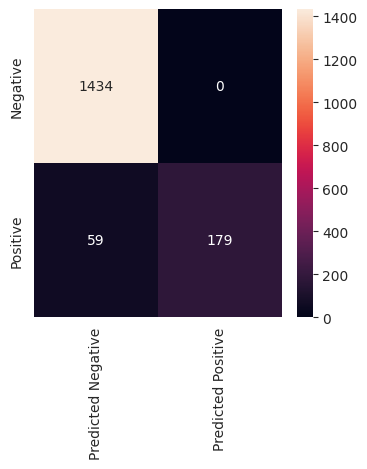

In [23]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
report = classification_report(mnb.predict(X_test), y_test)
print(report)
plot_confusion_matrix(y_test, mnb.predict(X_test))

## Complement Naive Bayes

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1401
           1       0.95      0.83      0.88       271

    accuracy                           0.96      1672
   macro avg       0.96      0.91      0.93      1672
weighted avg       0.96      0.96      0.96      1672



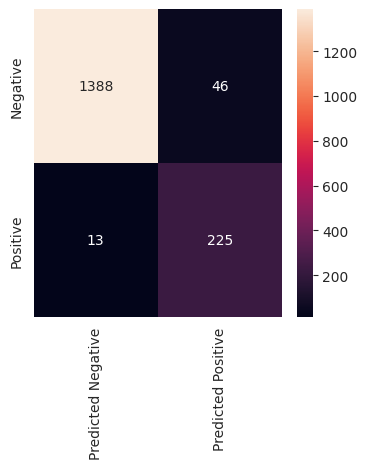

In [24]:
comnb = ComplementNB()
comnb.fit(X_train, y_train)
report = classification_report(comnb.predict(X_test), y_test)
print(report)
plot_confusion_matrix(y_test, comnb.predict(X_test))

# Binary CountVectorizer

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=RANDOM_SEED)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Creare un'istanza di CountVectorizer con binary=True
binary_vectorizer = CountVectorizer(stop_words="english", max_features=1000, binary=True)

# Trasformare i dati di addestramento
X_train_binary = binary_vectorizer.fit_transform(X_train)

# Trasformare i dati di test
X_test_binary = binary_vectorizer.transform(X_test)

## Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1459
           1       0.89      0.99      0.94       213

    accuracy                           0.98      1672
   macro avg       0.94      0.99      0.96      1672
weighted avg       0.98      0.98      0.98      1672



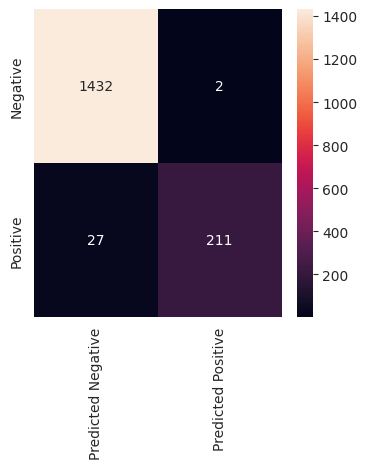

In [27]:
benb = BernoulliNB()
benb.fit(X_train_binary, y_train)
report = classification_report(benb.predict(X_test_binary), y_test)
print(report)
plot_confusion_matrix(y_test, benb.predict(X_test_binary))

### SMOTE Version

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1414
           1       0.95      0.88      0.91       258

    accuracy                           0.97      1672
   macro avg       0.96      0.93      0.95      1672
weighted avg       0.97      0.97      0.97      1672



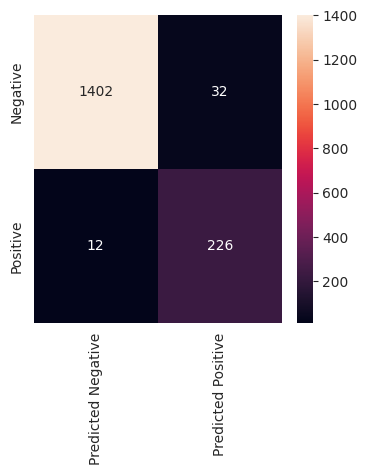

In [28]:
from imblearn.over_sampling import SMOTE
X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(X_train_binary, y_train)
benb = BernoulliNB()
benb.fit(X_resampled_smote, y_resampled_smote)
report = classification_report(benb.predict(X_test_binary), y_test)
print(report)
plot_confusion_matrix(y_test, benb.predict(X_test_binary))

## Multinomial Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1428
           1       0.93      0.91      0.92       244

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.95      1672
weighted avg       0.98      0.98      0.98      1672



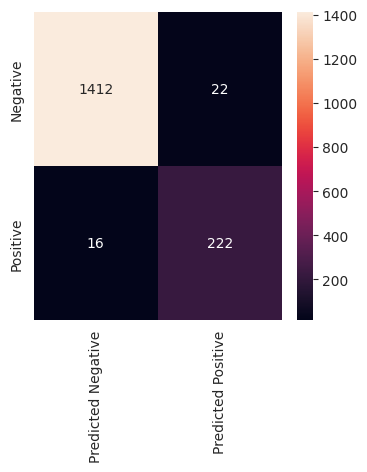

In [29]:
mnb = MultinomialNB()
mnb.fit(X_train_binary, y_train)
report = classification_report(mnb.predict(X_test_binary), y_test)
print(report)
plot_confusion_matrix(y_test, mnb.predict(X_test_binary))

## Complement Naive Bayes

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1378
           1       0.97      0.79      0.87       294

    accuracy                           0.96      1672
   macro avg       0.97      0.89      0.92      1672
weighted avg       0.96      0.96      0.96      1672



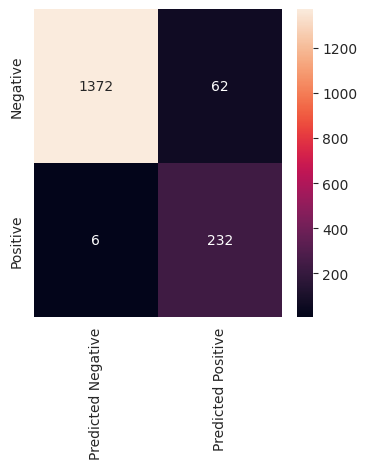

In [30]:
comnb = ComplementNB()
comnb.fit(X_train_binary, y_train)
report = classification_report(comnb.predict(X_test_binary), y_test)
print(report)
plot_confusion_matrix(y_test, comnb.predict(X_test_binary))